# Load Data

In [1]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.stats
from pathlib import Path
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as patches
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score)
from matplotlib.lines import Line2D

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load embeddings and aligned data

In [2]:
embeddings = torch.load("SHINE embeddings.pt")
emb_combined = embeddings['emb_combined']
emb_recon_transcript = embeddings['emb_recon_transcript']
emb_recon_metabolite = embeddings['emb_recon_metabolite']
emb_latent_transcript = embeddings['emb_latent_transcript']
emb_latent_metabolite = embeddings['emb_latent_metabolite']

In [3]:
transcript_info = pd.read_csv("aligned_ST_data.csv")
transcript_expr = transcript_info.iloc[:, 3:]
print(transcript_expr)
genes = transcript_expr.columns
genes

         ISG15    TTLL10  TNFRSF18     MXRA8    TMEM52    CFAP74     PLCH2  \
0     0.718045  0.000000  0.718045  1.131673  0.000000  0.000000  0.000000   
1     0.000000  0.000000  0.000000  0.712652  0.000000  0.000000  0.000000   
2     0.000000  0.824859  0.000000  2.002533  0.000000  0.824859  0.824859   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.000000  0.000000  0.000000  1.265771  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2136  0.000000  0.000000  1.125167  1.641220  0.000000  0.000000  0.000000   
2137  0.000000  0.687889  0.687889  0.687889  0.000000  0.000000  0.687889   
2138  1.572613  0.000000  0.000000  1.807025  0.000000  0.000000  0.821133   
2139  0.692847  0.000000  0.000000  1.791260  0.000000  0.000000  0.000000   
2140  0.000000  0.000000  0.000000  0.809613  0.809613  0.000000  0.000000   

        WRAP73      TP73    KCNAB2  ...      GPC3      FHL1    

Index(['ISG15', 'TTLL10', 'TNFRSF18', 'MXRA8', 'TMEM52', 'CFAP74', 'PLCH2',
       'WRAP73', 'TP73', 'KCNAB2',
       ...
       'GPC3', 'FHL1', 'LDOC1', 'CETN2', 'ZNF185', 'PNCK', 'ARHGAP4', 'RENBP',
       'FLNA', 'MPP1'],
      dtype='object', length=2000)

In [4]:
metabolite_info = pd.read_csv("aligned_SM_data.csv")
metabolite_abundance = metabolite_info.iloc[:, 3:]
print(metabolite_abundance)
metabolites = metabolite_abundance.columns
metabolites

      mz_255.23109612934098  mz_283.262461778844  mz_325.1826419711799  \
0                  4.501958             3.883207              3.019372   
1                  4.353744             3.999020              3.107966   
2                  4.347235             3.880859              3.423304   
3                  4.486656             4.132904              3.129611   
4                  4.617118             3.769865              3.141900   
...                     ...                  ...                   ...   
2136               4.205699             3.907992              3.175679   
2137               4.442237             3.725338              2.889263   
2138               4.422280             3.986589              3.305472   
2139               4.116458             4.015032              3.122130   
2140               4.414857             3.758658              3.645954   

      mz_311.1676841080394  mz_248.95872827128738  mz_339.1990497575424  \
0                 2.958029          

Index(['mz_255.23109612934098', 'mz_283.262461778844', 'mz_325.1826419711799',
       'mz_311.1676841080394', 'mz_248.95872827128738', 'mz_339.1990497575424',
       'mz_256.23444299891406', 'mz_112.98492851903', 'mz_297.15127632167696',
       'mz_284.2658086484171',
       ...
       'mz_272.22999598320604', 'mz_269.0140662769733', 'mz_477.2302905617134',
       'mz_947.5244869793153', 'mz_692.9527673663663', 'mz_362.1397349748619',
       'mz_697.4779777419988', 'mz_338.9279141150422', 'mz_846.6562282763398',
       'mz_275.82290572713964'],
      dtype='object', length=2082)

In [5]:
# Load original Visium AnnData
adata = sc.read_h5ad("LC_091.h5ad")
adata.var_names_make_unique()

# Load matched transcript and metabolite info
transcript_info = pd.read_csv("aligned_ST_data.csv", index_col='spot')

barcodes_filtered = transcript_info.index.intersection(adata.obs_names)
adata_filtered = adata[barcodes_filtered, :].copy()

transcript_info = transcript_info.loc[barcodes_filtered, :]
adata_filtered = adata_filtered[transcript_info.index, :]

adata_filtered.obsm['spatial'] = adata_filtered.obsm['spatial']
adata_filtered

AnnData object with n_obs × n_vars = 2141 × 16261
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'annotation'
    uns: 'msi', 'mz_features', 'orig.ident_colors', 'seurat_clusters_colors', 'spatial'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
    layers: 'log1p', 'raw'

In [6]:
assert emb_combined.shape[0] == adata_filtered.n_obs, "Mismatch in combined embedding rows!"

for factor_idx in range(emb_combined.shape[1]):
    adata_filtered.obs[f'latent_combined_{factor_idx+1}'] = emb_combined[:, factor_idx]

print(adata_filtered.obs.iloc[:, -10:].head())
adata_filtered

                      latent_combined_247  latent_combined_248  \
AACACTTGGCAAGGAA-1_1                  0.0             0.003884   
AACAGGATTCATAGTT-1_1                  0.0             0.001361   
AACAGGTTATTGCACC-1_1                  0.0             0.005243   
AACAGGTTCACCGAAG-1_1                  0.0             0.001201   
AACATAGTCTATCTAC-1_1                  0.0             0.004365   

                      latent_combined_249  latent_combined_250  \
AACACTTGGCAAGGAA-1_1             0.061681             0.015525   
AACAGGATTCATAGTT-1_1             0.061766             0.011939   
AACAGGTTATTGCACC-1_1             0.059260             0.016055   
AACAGGTTCACCGAAG-1_1             0.061875             0.011470   
AACATAGTCTATCTAC-1_1             0.062169             0.014654   

                      latent_combined_251  latent_combined_252  \
AACACTTGGCAAGGAA-1_1             0.027570             0.060097   
AACAGGATTCATAGTT-1_1             0.028651             0.057435   
AACAGGTT

AnnData object with n_obs × n_vars = 2141 × 16261
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'annotation', 'latent_combined_1', 'latent_combined_2', 'latent_combined_3', 'latent_combined_4', 'latent_combined_5', 'latent_combined_6', 'latent_combined_7', 'latent_combined_8', 'latent_combined_9', 'latent_combined_10', 'latent_combined_11', 'latent_combined_12', 'latent_combined_13', 'latent_combined_14', 'latent_combined_15', 'latent_combined_16', 'latent_combined_17', 'latent_combined_18', 'latent_combined_19', 'latent_combined_20', 'latent_combined_21', 'latent_combined_22', 'latent_combined_23', 'latent_combined_24', 'latent_combined_25', 'latent_combined_26', 'latent_combined_27', 'latent_combined_28', 'latent_combined_29', 'latent_combined_30', 'latent_combined_31', 'latent_combined_32', 'latent_combined_33', 'latent_combined_34', 'latent_combined_35', 'latent_combined_36', 'latent_combined_37', 'l

In [7]:
for factor_idx in range(emb_combined.shape[1]):
    adata_filtered.obs[f'latent_combined_{factor_idx}'] = emb_combined[:, factor_idx]

adata_filtered.obs.head()


,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,annotation,latent_combined_1,latent_combined_2,...,latent_combined_248,latent_combined_249,latent_combined_250,latent_combined_251,latent_combined_252,latent_combined_253,latent_combined_254,latent_combined_255,latent_combined_256,latent_combined_0
AACACTTGGCAAGGAA-1_1,LC_091,9756,4630,9525,4585,1,1,Tumor,0.078733,0.121147,...,0.061681,0.015525,0.027570,0.060097,0.0,0.069674,0.0,0.053912,0.053912,0.0
AACAGGATTCATAGTT-1_1,LC_091,74935,9618,9622,4479,3,3,Tumor,0.079327,0.123144,...,0.061766,0.011939,0.028651,0.057435,0.0,0.071114,0.0,0.052271,0.052271,0.0
AACAGGTTATTGCACC-1_1,LC_091,4257,2405,7803,2516,11,11,Normal cells,0.079613,0.120739,...,0.059260,0.016055,0.025204,0.063536,0.0,0.069056,0.0,0.053035,0.053035,0.0
AACAGGTTCACCGAAG-1_1,LC_091,72011,9178,9751,4352,3,3,Tumor,0.079249,0.123335,...,0.061875,0.011470,0.029280,0.056830,0.0,0.071741,0.0,0.051905,0.051905,0.0
AACATAGTCTATCTAC-1_1,LC_091,4344,2578,7862,2650,1,1,Normal cells,0.079336,0.122024,...,0.062169,0.014654,0.027698,0.060055,0.0,0.070666,0.0,0.053976,0.053976,0.0


## Annotation

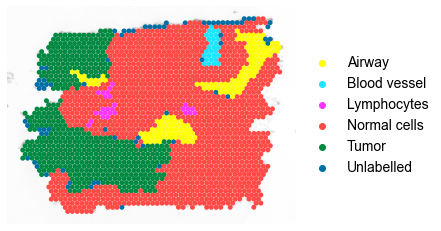

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ---------------------------------------------------------
# Global font settings
# ---------------------------------------------------------
rcParams["font.family"] = "Arial"
rcParams["font.size"] = 16
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["legend.fontsize"] = 14

library_id = "LC_091"

# ---------------------------------------------------------
# Spatial visualization (annotation)
# ---------------------------------------------------------
cats = adata.obs["annotation"].astype("category").cat.categories.tolist()
base_palette = sc.pl.palettes.default_102
palette = dict(zip(cats, base_palette[:len(cats)]))

axs = sc.pl.spatial(
    adata,
    library_id=library_id,
    img_key="hires",
    color="annotation",     # visualize annotations
    size=1.5,
    palette=palette,
    alpha_img=0.6,
    bw=True,
    show=False,
    title=""
)

# Hide axes
if isinstance(axs, (list, tuple)):
    for ax in axs:
        ax.axis("off")
else:
    axs.axis("off")

# ---------------------------------------------------------
# Save figure
# ---------------------------------------------------------
plt.savefig(
    f"{library_id}_annotation_spatial.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0
)
plt.show()


# Clustering

## ST latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


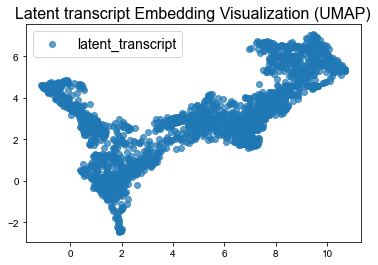

In [9]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_latent_transcript_umap = umap_reducer.fit_transform(emb_latent_transcript)

plt.scatter(reduced_latent_transcript_umap[:, 0], reduced_latent_transcript_umap[:, 1], label="latent_transcript", alpha=0.7)
plt.legend()
plt.title("Latent transcript Embedding Visualization (UMAP)")
plt.show()

adata = adata_filtered
adata.obsm['umap_latent_transcript'] = reduced_latent_transcript_umap

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


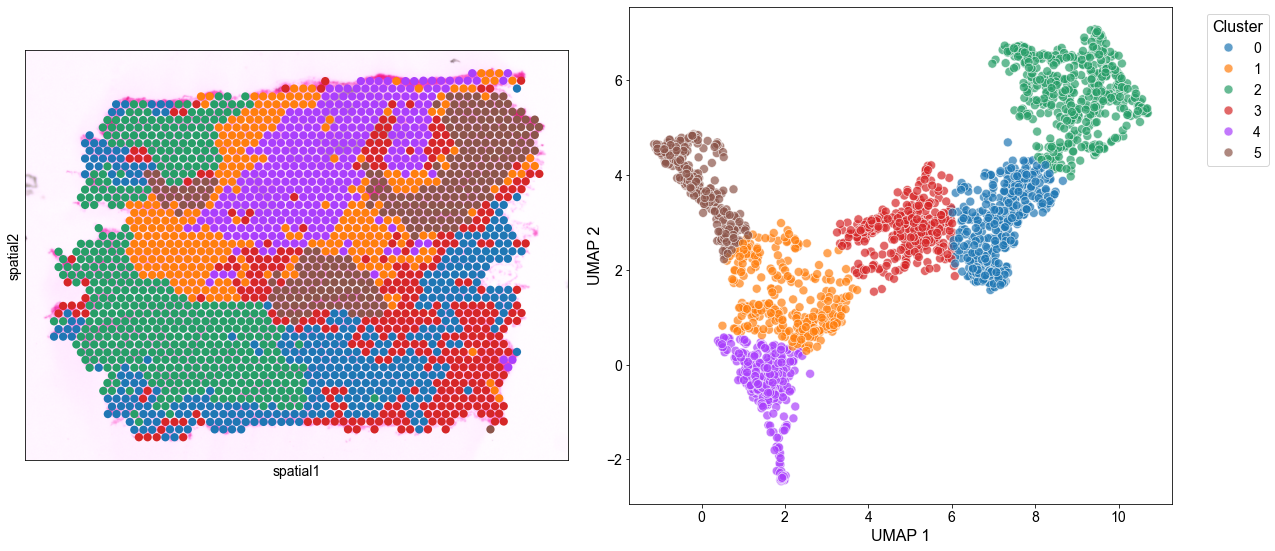

In [10]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

n_clusters =6

X = adata.obsm['umap_latent_transcript']
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

cats = [str(i) for i in range(n_clusters)]
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].astype('category')
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].cat.set_categories(cats, ordered=True)

base_palette = sc.pl.palettes.default_20[:n_clusters]
palette_dict = {c: base_palette[i] for i, c in enumerate(cats)}

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    library_id='LC_091',   
    img_key='hires',
    spot_size=20.0,
    palette=[palette_dict[c] for c in cats],  
    legend_loc=None,
    title='',
    ax=axes[0],            
    show=False
)

sns.scatterplot(
    x=X[:, 0], y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette_dict,
    s=80, alpha=0.7,
    ax=axes[1],
    hue_order=cats,        
    legend='full'
)

axes[1].set_xlabel('UMAP 1', fontsize=16)
axes[1].set_ylabel('UMAP 2', fontsize=16)
axes[0].title.set_fontsize(16)
axes[1].title.set_fontsize(16)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

leg = axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(leg.get_texts(), fontsize=14)
plt.setp(leg.get_title(), fontsize=16)

plt.tight_layout()
plt.savefig('SHINE-ST.svg', format='svg', bbox_inches='tight')
plt.show()

In [11]:
# Embedding used for clustering evaluation
X = adata.obsm["umap_latent_transcript"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")


# ---------------------------------------------------------
# External clustering validity metrics (against cell types)
# ---------------------------------------------------------
# Choose the object for evaluation
# If clustering was performed on adata_filtered, set obj = adata_filtered
obj = adata

# If "Cell type" is not available, copy from "annotation"
if "Cell type" not in obj.obs.columns and "annotation" in obj.obs.columns:
    obj.obs["Cell type"] = obj.obs["annotation"].copy()

# Valid index mask (ensure consistency with filtered data if applicable)
valid_idx = (
    np.ones(obj.shape[0], dtype=bool)
    if 'valid_idx' not in locals()
    else valid_idx
)

# Select valid observations
m = (
    valid_idx
    & obj.obs["Cell type"].notna().values
    & obj.obs["umap_based_clusters"].notna().values
)

y_true = obj.obs.loc[m, "Cell type"].astype(str).str.strip().values
y_pred = obj.obs.loc[m, "umap_based_clusters"].astype(str).str.strip().values

# Compute external clustering metrics
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ---------------------------------------------------------
# Confusion matrix (cell type vs cluster assignment)
# ---------------------------------------------------------
cm = pd.crosstab(
    pd.Series(y_true, name="Cell type"),
    pd.Series(y_pred, name="umap_based_clusters")
)

print("\nConfusion matrix (Cell type vs clusters):")
print(cm)

Silhouette Score: 0.493
Calinski-Harabasz Index: 6438.279
Davies-Bouldin Index: 0.729
=== Clustering metrics ===
ARI: 0.199
NMI: 0.352
AMI: 0.349
Homogeneity: 0.468
Completeness: 0.282
V-measure: 0.352
FMI: 0.443

Confusion matrix (Cell type vs clusters):
umap_based_clusters    0    1    2    3    4    5
Cell type                                        
Airway                 0    0    1    0    0  157
Blood vessel           0    0    0    2   27    0
Lymphocytes            0   20    0    0    7    0
Normal cells         300  271   38  320  275  103
Tumor                 74   11  420   32    0   11
Unlabelled            10   10   24    5   14    9


## SM latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


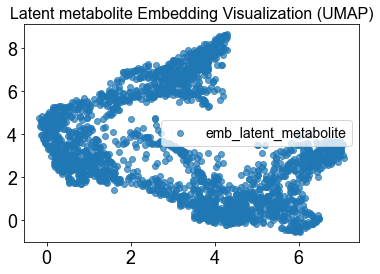

In [12]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_latent_metabolite_umap = umap_reducer.fit_transform(emb_latent_metabolite)

plt.scatter(reduced_latent_metabolite_umap[:, 0], reduced_latent_metabolite_umap[:, 1], label="emb_latent_metabolite", alpha=0.7)
plt.legend()
plt.title("Latent metabolite Embedding Visualization (UMAP)")
plt.show()

adata = adata_filtered
adata.obsm['umap_latent_metabolite'] = reduced_latent_metabolite_umap

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


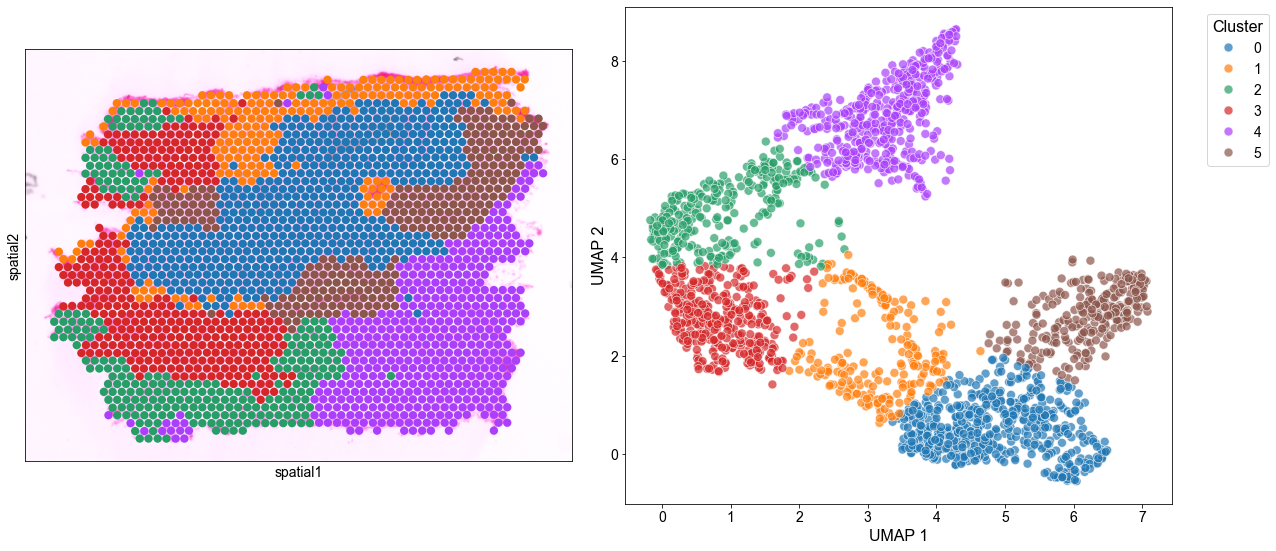

In [13]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

n_clusters =6

X = adata.obsm['umap_latent_metabolite']

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

cats = [str(i) for i in range(n_clusters)]
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].astype('category')
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].cat.set_categories(cats, ordered=True)

base_palette = sc.pl.palettes.default_20[:n_clusters]
palette_dict = {c: base_palette[i] for i, c in enumerate(cats)}

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    library_id='LC_091',   
    img_key='hires',
    spot_size=20.0,
    palette=[palette_dict[c] for c in cats],  
    legend_loc=None,
    title='',
    ax=axes[0],          
    show=False
)

sns.scatterplot(
    x=X[:, 0], y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette_dict,
    s=80, alpha=0.7,
    ax=axes[1],
    hue_order=cats,       
    legend='full'
)

axes[1].set_xlabel('UMAP 1', fontsize=16)
axes[1].set_ylabel('UMAP 2', fontsize=16)
axes[0].title.set_fontsize(16)
axes[1].title.set_fontsize(16)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

leg = axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(leg.get_texts(), fontsize=14)
plt.setp(leg.get_title(), fontsize=16)

plt.tight_layout()
plt.savefig('SHINE-SM.svg', format='svg', bbox_inches='tight')
plt.show()


In [14]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Embedding used for clustering evaluation
X = adata.obsm["umap_latent_metabolite"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

# ---------------------------------------------------------
# External clustering validity metrics (against cell types)
# ---------------------------------------------------------
# Choose the object for evaluation
# If clustering was performed on adata_filtered, set obj = adata_filtered
obj = adata

# If "Cell type" is not available, copy from "annotation"
if "Cell type" not in obj.obs.columns and "annotation" in obj.obs.columns:
    obj.obs["Cell type"] = obj.obs["annotation"].copy()

# Valid index mask (ensure consistency with filtered data if applicable)
valid_idx = (
    np.ones(obj.shape[0], dtype=bool)
    if 'valid_idx' not in locals()
    else valid_idx
)

# Select valid observations
m = (
    valid_idx
    & obj.obs["Cell type"].notna().values
    & obj.obs["umap_based_clusters"].notna().values
)

y_true = obj.obs.loc[m, "Cell type"].astype(str).str.strip().values
y_pred = obj.obs.loc[m, "umap_based_clusters"].astype(str).str.strip().values

# Compute external clustering metrics
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ---------------------------------------------------------
# Confusion matrix (cell type vs cluster assignment)
# ---------------------------------------------------------
cm = pd.crosstab(
    pd.Series(y_true, name="Cell type"),
    pd.Series(y_pred, name="umap_based_clusters")
)

print("\nConfusion matrix (Cell type vs clusters):")
print(cm)

Silhouette Score: 0.493
Calinski-Harabasz Index: 4288.508
Davies-Bouldin Index: 0.705
=== Clustering metrics ===
ARI: 0.237
NMI: 0.347
AMI: 0.344
Homogeneity: 0.456
Completeness: 0.280
V-measure: 0.347
FMI: 0.478

Confusion matrix (Cell type vs clusters):
umap_based_clusters    0    1    2    3    4    5
Cell type                                        
Airway                 6    7    2    4    0  139
Blood vessel          23    6    0    0    0    0
Lymphocytes           23    0    0    0    0    4
Normal cells         474  140  120    6  455  112
Tumor                 14   56  141  320    2   15
Unlabelled             6   28   13   18    1    6


## SHINE latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


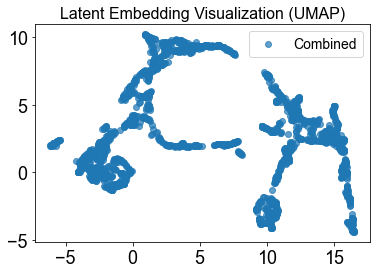

In [15]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_combined_umap = umap_reducer.fit_transform(emb_combined)

plt.scatter(reduced_combined_umap[:, 0], reduced_combined_umap[:, 1], label="Combined", alpha=0.7)
plt.legend()
plt.title("Latent Embedding Visualization (UMAP)")
plt.show()

adata = adata_filtered
adata.obsm['umap_combined'] = reduced_combined_umap

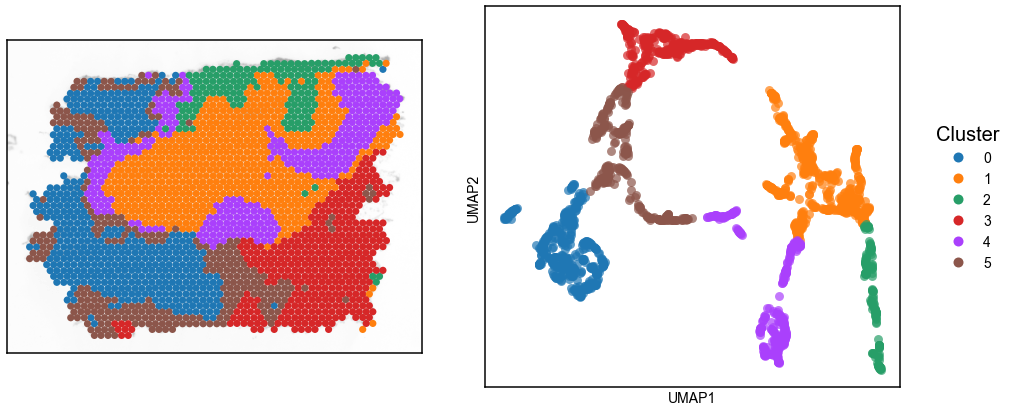

In [16]:
# -----------------------------
# 1) Global plotting style
# -----------------------------
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20

# -----------------------------
# 2) KMeans clustering on UMAP embedding
# -----------------------------
n_clusters = 6
X = adata.obsm['umap_combined']

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

# Recommended: fix category order to ensure stable color mapping
cats = sorted(
    adata.obs['umap_based_clusters'].unique(),
    key=lambda x: int(x) if x.isdigit() else x
)

# -----------------------------
# 3) Color mapping: cluster -> color
# -----------------------------
palette = sc.pl.palettes.default_20[:n_clusters]
palette_dict = {c: palette[i] for i, c in enumerate(cats)}

# -----------------------------
# 4) Canvas: 1 row × 2 columns (left: Spatial, right: UMAP)
# -----------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 7),
    gridspec_kw={"wspace": 0.15}
)

# ===== Left panel: Spatial (disable built-in legend to avoid duplication) =====
sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    library_id='LC_091',
    img_key='hires',
    palette=[palette_dict[c] for c in cats],  # enforce mapping order
    size=1.5,
    bw=True,
    alpha_img=0.6,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title=""
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

# ===== Right panel: UMAP (colors consistent with Spatial) =====
for c in cats:
    mask = (adata.obs['umap_based_clusters'].values == c)
    axes[1].scatter(
        X[mask, 0],
        X[mask, 1],
        s=80,
        alpha=0.7,
        c=[palette_dict[c]],
        linewidths=0
    )

axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].set_title("")

axes[1].set_xticks([])
axes[1].set_yticks([])

for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

# -----------------------------
# 5) Global legend (single legend on the right)
# -----------------------------
handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=10,
        markerfacecolor=palette_dict[c],
        markeredgecolor='none',
        label=c
    )
    for c in cats
]

leg = fig.legend(
    handles=handles,
    title="Cluster",
    loc="center left",
    bbox_to_anchor=(0.92, 0.5),
    frameon=False
)
leg.get_title().set_fontsize('medium')

# -----------------------------
# 6) Save figure
# -----------------------------
plt.savefig('SHINE.svg', format='svg', bbox_inches='tight')
plt.show()


In [17]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# Internal clustering validity metrics (unsupervised)
# ---------------------------------------------------------
# Low-dimensional embedding used for clustering
X = adata.obsm['umap_combined']

# Cluster labels
labels = adata.obs['umap_based_clusters'].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f'Silhouette Score: {sil_score:.3f}')

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Index: {ch_score:.3f}')

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_score:.3f}')

# ---------------------------------------------------------
# External clustering validity metrics (against cell types)
# ---------------------------------------------------------
# Choose the object for evaluation
# If clustering was performed on adata_filtered, set obj = adata_filtered
obj = adata

# If "Cell type" is not available, copy from "annotation"
if "Cell type" not in obj.obs.columns and "annotation" in obj.obs.columns:
    obj.obs["Cell type"] = obj.obs["annotation"].copy()

# Valid index mask (ensure consistency with filtered data if applicable)
valid_idx = (
    np.ones(obj.shape[0], dtype=bool)
    if 'valid_idx' not in locals()
    else valid_idx
)

# Select valid observations
m = (
    valid_idx
    & obj.obs["Cell type"].notna().values
    & obj.obs["umap_based_clusters"].notna().values
)

y_true = obj.obs.loc[m, "Cell type"].astype(str).str.strip().values
y_pred = obj.obs.loc[m, "umap_based_clusters"].astype(str).str.strip().values

# Compute external clustering metrics
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ---------------------------------------------------------
# Confusion matrix (cell type vs cluster assignment)
# ---------------------------------------------------------
cm = pd.crosstab(
    pd.Series(y_true, name="Cell type"),
    pd.Series(y_pred, name="umap_based_clusters")
)

print("\nConfusion matrix (Cell type vs clusters):")
print(cm)


Silhouette Score: 0.501
Calinski-Harabasz Index: 4513.047
Davies-Bouldin Index: 0.738
=== Clustering metrics ===
ARI: 0.260
NMI: 0.412
AMI: 0.409
Homogeneity: 0.538
Completeness: 0.334
V-measure: 0.412
FMI: 0.499

Confusion matrix (Cell type vs clusters):
umap_based_clusters    0    1   2    3    4    5
Cell type                                       
Airway                 1    2   0    0  155    0
Blood vessel           0    1  28    0    0    0
Lymphocytes            0   27   0    0    0    0
Normal cells          30  529  99  360  125  164
Tumor                393    1   0    1   17  136
Unlabelled            29    4  23    0   10    6


Cluster composition (%):


Cell type,Airway,Blood vessel,Lymphocytes,Normal cells,Tumor,Unlabelled
Cluster,,,,,,
0,0.2,0.0,0.0,6.6,86.8,6.4
1,0.4,0.2,4.8,93.8,0.2,0.7
2,0.0,18.7,0.0,66.0,0.0,15.3
3,0.0,0.0,0.0,99.7,0.3,0.0
4,50.5,0.0,0.0,40.7,5.5,3.3
5,0.0,0.0,0.0,53.6,44.4,2.0


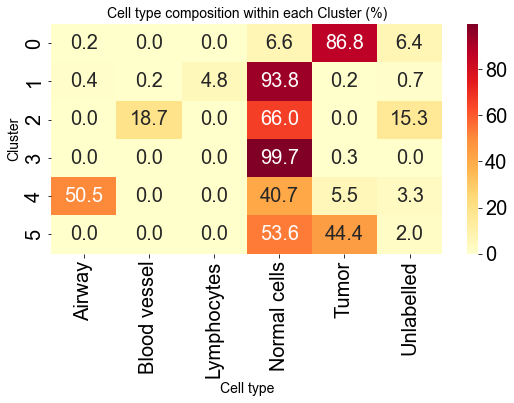

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Cluster": y_pred,
    "Cell type": y_true
})

cluster_comp = (
    pd.crosstab(df["Cluster"], df["Cell type"], normalize="index") * 100
).round(1)

print("Cluster composition (%):")
display(cluster_comp)
 

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_comp, annot=True, cmap="YlOrRd", fmt=".1f")
plt.title("Cell type composition within each Cluster (%)", fontsize=14)
plt.ylabel("Cluster")
plt.xlabel("Cell type")
plt.tight_layout()
plt.savefig('Heatmap.svg', format='svg', bbox_inches='tight')
plt.show()


# Comparison

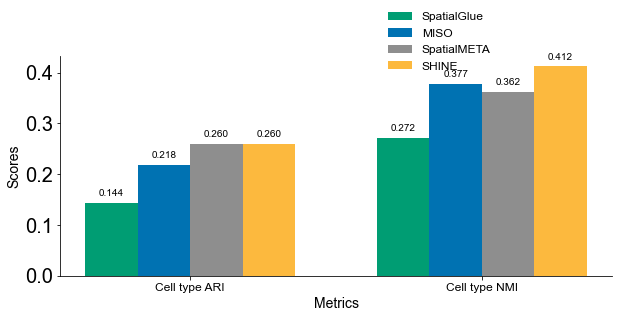

In [19]:
plt.rcParams['font.family'] = 'Arial'
indicators = ['Cell type ARI', 'Cell type NMI']

SpatialGlue = [0.144,0.272]     
MISO = [0.218,0.377] 
SpatialMETA  = [0.260, 0.362]
SHINE = [0.260,0.412]

methods = ['SpatialGlue', 'MISO', 'SpatialMETA', 'SHINE']
colors = ['#009D73', '#0072b2', '#8E8E8E', '#fcb93e']  

data = np.array([
    SpatialGlue,
    MISO,
    SpatialMETA,
    SHINE
])

x = np.arange(len(indicators))
width = 0.18  

fig, ax = plt.subplots(figsize=(9, 5))

rects = []
for i, method in enumerate(methods):
    rect = ax.bar(
        x + (i - (len(methods)-1)/2) * width,
        data[i],
        width,
        label=method,
        color=colors[i]
    )
    rects.append(rect)

ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(indicators, fontsize=12)

ax.legend(
    fontsize=12,
    loc='upper right',
    bbox_to_anchor=(0.8, 1.25),
    frameon=False
)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height:.3f}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 5),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=10,
            fontfamily='Arial'
        )

for rect_group in rects:
    autolabel(rect_group)

fig.tight_layout()

plt.savefig('metrics_comparison.svg',
            format='svg',
            bbox_inches='tight')

plt.show()


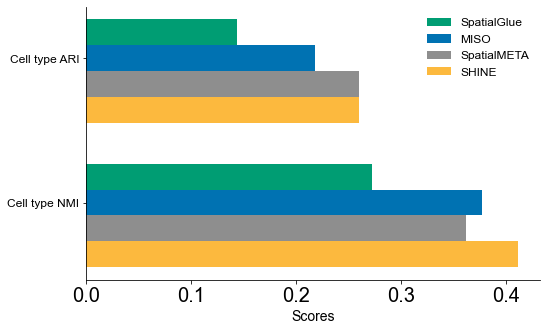

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
y = np.arange(len(indicators))
for i, method in enumerate(methods):
    ax.barh(y + (i - 1) * width, data[i], height=width, label=method, color=colors[i])

ax.set_yticks(y)
ax.set_yticklabels(indicators, fontsize=12)
ax.set_xlabel("Scores", fontsize=14)
ax.legend(fontsize=12, frameon=False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.invert_yaxis()

plt.tight_layout()
plt.savefig('metrics_comparison.svg', format='svg', bbox_inches='tight')

plt.show()